# This is the model training part of my League of Legends real-time prediction project.

### Below are some required packages for training the model.

In [1]:
!pip install pandas
!pip install seaborn
!pip install plotly
!pip install -U scikit-learn
!pip install xgboost

In [1]:
import pandas as pd
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

### The dataset is obtained from riot api by fetching all challenger, grandmaster, master players' matches recently. The raw fetched dataset is preprocessed to avoid duplicates of matches, and certain import game features are cleaned into csv for model trainning purpose. 

In [134]:
#obtain dataset
file_path = "match_data.csv"
df = pd.read_csv(file_path)

In [135]:
df.describe()

,gameId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,...,t2_dragonKills,t2_riftHeraldKills,t2_totalGold,t2_totalLevel,t2_avgLevel,t2_totalMinionKills,t2_totalJungleMinionKills,t2_totalKills,t2_totalDeath,t2_totalAssist
count,4.906300e+04,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,...,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000
mean,4.830716e+09,1.503271,1.491348,1.157797,1.247926,0.869780,1.199234,1.157736,4.793408,0.847482,...,1.484275,0.635224,59233.734301,73.732793,14.746559,528.604753,126.812914,34.559179,34.524734,59.432587
std,6.403314e+06,0.499994,0.512254,0.761903,0.719554,0.838967,0.782533,0.738703,3.420099,1.064008,...,1.406972,0.741077,16479.825777,12.636222,2.527244,205.527186,77.241291,17.046219,17.085266,44.278045
min,4.745276e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,12773.000000,25.000000,5.000000,13.000000,0.000000,0.000000,0.000000,0.000000
25%,4.829145e+09,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,48322.500000,65.000000,13.000000,355.000000,87.000000,22.000000,22.000000,28.000000
50%,4.832694e+09,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,...,1.000000,0.000000,60094.000000,75.000000,15.000000,564.000000,139.000000,33.000000,33.000000,47.000000
75%,4.834641e+09,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000,1.000000,...,3.000000,1.000000,70183.000000,84.000000,16.800000,680.000000,182.000000,44.000000,44.000000,74.000000
max,4.836633e+09,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,11.000000,9.000000,...,6.000000,2.000000,153277.000000,90.000000,18.000000,1325.000000,433.000000,134.000000,129.000000,289.000000


In [136]:
df.columns

Index(['gameId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1Name',
       't1_champ2Name', 't1_champ3Name', 't1_champ4Name', 't1_champ5Name',
       't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't1_totalGold', 't1_totalLevel', 't1_avgLevel',
       't1_totalMinionKills', 't1_totalJungleMinionKills', 't1_totalKills',
       't1_totalDeath', 't1_totalAssist', 't2_champ1Name', 't2_champ2Name',
       't2_champ3Name', 't2_champ4Name', 't2_champ5Name', 't2_towerKills',
       't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills', 't2_totalGold', 't2_totalLevel', 't2_avgLevel',
       't2_totalMinionKills', 't2_totalJungleMinionKills', 't2_totalKills',
       't2_totalDeath', 't2_totalAssist'],
      dtype='object')

In [137]:
print('Total entrances:', df.shape[0], '.')
print('Total fields for each entrance:', df.shape[1], '.')

Total entrances: 49063 .
Total fields for each entrance: 44 .


In [138]:
print('Total of missing values found:', df.isna().sum().sum(), '.')

Total of missing values found: 0 .


In [139]:
df = df.dropna()

In [140]:
print('Total of missing values found:', df.isna().sum().sum(), '.')

Total of missing values found: 0 .


In [141]:
ft = df.drop(['t1_champ1Name','t1_champ2Name', 't1_champ3Name', 't1_champ4Name', 't1_champ5Name','t2_champ1Name', 't2_champ2Name',
       't2_champ3Name', 't2_champ4Name', 't2_champ5Name'], axis=1)

In [142]:
ft.columns

Index(['gameId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't1_totalGold', 't1_totalLevel', 't1_avgLevel',
       't1_totalMinionKills', 't1_totalJungleMinionKills', 't1_totalKills',
       't1_totalDeath', 't1_totalAssist', 't2_towerKills', 't2_inhibitorKills',
       't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_totalGold',
       't2_totalLevel', 't2_avgLevel', 't2_totalMinionKills',
       't2_totalJungleMinionKills', 't2_totalKills', 't2_totalDeath',
       't2_totalAssist'],
      dtype='object')

In [143]:
# define dataset columns
ft = ft.drop(['gameId', 'winner'], axis=1)

In [144]:
ft["GoldDiff"] = ft.t1_totalGold - ft.t2_totalGold
ft["KillDiff"] = ft.t1_totalKills - ft.t2_totalKills
ft["DeathDiff"] = ft.t1_totalDeath - ft.t2_totalDeath
ft["AssistDiff"] = ft.t1_totalAssist - ft.t2_totalAssist
ft["LvlDiff"] = ft.t1_avgLevel - ft.t2_avgLevel
ft["CsDiff"] = ft.t1_totalMinionKills - ft.t2_totalMinionKills
ft["JungleCsDiff"] = ft.t1_totalJungleMinionKills - ft.t2_totalJungleMinionKills

In [145]:
ft = ft.drop([
    't1_totalGold',
    't1_totalLevel',
    't1_avgLevel',
    't1_totalMinionKills',
    't1_totalJungleMinionKills',
    't1_totalKills',
    't1_totalDeath',
    't1_totalAssist',
    't2_totalGold',
    't2_totalLevel',
    't2_avgLevel',
    't2_totalMinionKills',
    't2_totalJungleMinionKills',
    't2_totalKills',
    't2_totalDeath',
    't2_totalAssist',
    'firstBaron',
    'firstRiftHerald',
    'GoldDiff',
    't1_baronKills'
], axis=1)

In [146]:
ft = ft.drop([
    't2_towerKills',
    't2_inhibitorKills',
    't2_baronKills',
    't2_dragonKills',
    't2_riftHeraldKills',
    
], axis=1)

In [147]:
ft.rename(columns = {'LvlDiff':'Lv_Diff',
                     'CsDiff':'cs_Diff',
                     'JungleCsDiff':'jg_cs_Diff',
                     'KillDiff':'Kills_Diff',
                     'AssistDiff':'Assist_Diff',
                     'DeathDiff':'Death_Diff',
                     't1_riftHeraldKills': 'riftHeralds_amount',
                     't1_dragonKills':'Dragons_Amount',
                     't1_inhibitorKills':'inhibs_amount',
                     't1_towerKills':'tower_amount',
#                      't1_baronKills':'baron_amount',
                    }, inplace = True)

In [148]:
ft.columns

Index(['firstBlood', 'firstTower', 'firstInhibitor', 'firstDragon',
       'tower_amount', 'inhibs_amount', 'Dragons_Amount', 'riftHeralds_amount',
       'Kills_Diff', 'Death_Diff', 'Assist_Diff', 'Lv_Diff', 'cs_Diff',
       'jg_cs_Diff'],
      dtype='object')

In [149]:
ft.head()

,firstBlood,firstTower,firstInhibitor,firstDragon,tower_amount,inhibs_amount,Dragons_Amount,riftHeralds_amount,Kills_Diff,Death_Diff,Assist_Diff,Lv_Diff,cs_Diff,jg_cs_Diff
0,2,0,1,2,11,3,3,1,16,-16,31,1.2,-31,56
1,2,2,0,2,1,0,0,0,-27,27,-28,-1.4,-62,-36
2,1,2,2,2,5,0,1,0,-15,15,-13,-1.8,-59,-61
3,2,1,1,2,8,1,1,1,17,-17,24,1.8,43,35
4,1,1,2,1,6,0,3,2,-2,2,-32,-0.4,99,58


In [150]:
#Set the train and test dataset
X = ft
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [151]:
print('datset')
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,sep="\n")


datset
(39250, 14)
(9813, 14)
(39250,)
(9813,)


In [152]:
# Train pre game model
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

model = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_model.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found for pre game: ", grid_model.best_params_)

# Evaluate the best model
tuned_model = grid_model.best_estimator_

y_pred = tuned_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM Model Accuracy with Best Parameters: {accuracy:.2%}")



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found for pre game:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
GBM Model Accuracy with Best Parameters: 97.22%


In [154]:
# Save the model for further uses
joblib.dump(tuned_model, 'tuned_model.joblib')

['tuned_model.joblib']

In [83]:
# # Train early game model
# model_early_game = GradientBoostingClassifier(random_state=42)

# # Initialize GridSearchCV
# grid_model_early_game = GridSearchCV(estimator=model_early_game, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_model_early_game.fit(X_train_early, y_train_early)

# # Print the best parameters
# print("Best parameters found for early game: ", grid_model_early_game.best_params_)

# # Evaluate the best model
# tuned_model_early_game = grid_model_early_game.best_estimator_

# y_pred_early = tuned_model_early_game.predict(X_test_early)
# accuracy = accuracy_score(y_test_early, y_pred_early)
# print(f"GBM Model Accuracy with Best Parameters: {accuracy:.2%}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found for early game:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
GBM Model Accuracy with Best Parameters: 87.48%


In [72]:
# # Train late game model
# model_late_game = GradientBoostingClassifier(random_state=42)

# # Initialize GridSearchCV
# grid_model_late_game = GridSearchCV(estimator=model_late_game, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_model_late_game.fit(X_train_late, y_train_late)

# # Print the best parameters
# print("Best parameters found for late game: ", grid_model_late_game.best_params_)

# # Evaluate the best model
# tuned_model_late_game = grid_model_late_game.best_estimator_

# y_pred_late = tuned_model_late_game.predict(X_test_late)
# accuracy = accuracy_score(y_test_late, y_pred_late)
print(f"GBM Model Accuracy with Best Parameters: {accuracy:.2%}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found for late game:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
GBM Model Accuracy with Best Parameters: 96.47%


In [ ]:
['blueWins', 'first_blood', 'first_tower', 'first_inhib', 'mid_towers_amount', 'top_towers_amount', 
 'bot_towers_amount', 'inhibs_amount', 'first_dragon', 'Dragons_Amount', 'Heralds_amount', 'Kills_Diff', 
 'Death_Diff', 'Assist_Diff', 'Lvl_Diff', 'cs_Diff', 'jungle_cs_Diff']

In [ ]:
#team mean pics

In [ ]:
first_team = df[df.winner==1]
second_team = df[df.winner==2]

In [ ]:
# Calculate the number of wins for each team and first blood combination
win_counts = df.groupby(["winner", "firstBlood"]).size().reset_index(name="count")
# Calculate the total number of wins for each team
team_1_wins = win_counts[win_counts["winner"] == 1]["count"].sum()
team_2_wins = win_counts[win_counts["winner"] == 2]["count"].sum()
# Calculate the proportions of wins for team 1 when they had first blood, opponent had first blood, or in rematches
team_1_win_first_blood_for_team_1 = win_counts[(win_counts["winner"] == 1) & (win_counts["firstBlood"] == 1)]["count"].values[0] / team_1_wins
team_1_win_first_blood_for_team_2 = win_counts[(win_counts["winner"] == 1) & (win_counts["firstBlood"] == 2)]["count"].values[0] / team_1_wins
team_1_win_first_blood_for_remake = win_counts[(win_counts["winner"] == 1) & (win_counts["firstBlood"] == 0)]["count"].values[0] / team_1_wins
# Calculate the proportions of wins for team 2 when they had first blood, opponent had first blood, or in rematches
team_2_win_first_blood_for_team_1 = win_counts[(win_counts["winner"] == 2) & (win_counts["firstBlood"] == 1)]["count"].values[0] / team_2_wins
team_2_win_first_blood_for_team_2 = win_counts[(win_counts["winner"] == 2) & (win_counts["firstBlood"] == 2)]["count"].values[0] / team_2_wins
team_2_win_first_blood_for_remake = win_counts[(win_counts["winner"] == 2) & (win_counts["firstBlood"] == 0)]["count"].values[0] / team_2_wins
# Print the results
print(f"Proportion of wins for team 1 when they had the first blood: {team_1_win_first_blood_for_team_1:.1%}"
,f"Proportion of wins for team 1 when the opponent had the first blood: {team_1_win_first_blood_for_team_2:.1%}"
,f"Proportion of wins for team 1 in rematches: {team_1_win_first_blood_for_remake:.1%}",sep='\n')
print(f"Proportion of wins for team 2 when they had the first blood: {team_2_win_first_blood_for_team_1:.1%}"
,f"Proportion of wins for team 2 when the opponent had the first blood: {team_2_win_first_blood_for_team_2:.1%}"
,f"Proportion of wins for team 2 in rematches: {team_2_win_first_blood_for_remake:.1%}",sep='\n')

Proportion of wins for team 1 when they had the first blood: 58.4%
Proportion of wins for team 1 when the opponent had the first blood: 40.2%
Proportion of wins for team 1 in rematches: 1.4%
Proportion of wins for team 2 when they had the first blood: 41.2%
Proportion of wins for team 2 when the opponent had the first blood: 57.5%
Proportion of wins for team 2 in rematches: 1.3%


In [ ]:
Towers_Barons_Drakes_Inhib=df[["winner","t1_towerKills","t1_inhibitorKills","t1_baronKills","t1_dragonKills","t2_towerKills","t2_inhibitorKills","t2_baronKills","t2_dragonKills"]]
Towers_Barons_Drakes_Inhib.groupby("winner").mean()
Towers_Barons_Drakes_Inhib.groupby("winner").mean().plot(kind="bar",subplots=True,sharex=False,sharey=False,figsize=(20,10),layout=(2,4),title="Details of each team for winning his game")
plt.savefig("Details_of_winning_team", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#details of winning team

In [ ]:
df = df.drop(["gameId", "creationTime", "seasonId", "t1_champ1id", "t1_champ1_sum1", "t1_champ1_sum2", "t1_champ2id", "t1_champ2_sum1", "t1_champ2_sum2", "t1_champ3id", "t1_champ3_sum1", "t1_champ3_sum2", "t1_champ4id", "t1_champ4_sum1", "t1_champ4_sum2", "t1_champ5id", "t1_champ5_sum1", "t1_champ5_sum2", "t2_champ1id", "t2_champ1_sum1", "t2_champ1_sum2", "t2_champ2id", "t2_champ2_sum1", "t2_champ2_sum2", "t2_champ3id", "t2_champ3_sum1", "t2_champ3_sum2", "t2_champ4id", "t2_champ4_sum1", "t2_champ4_sum2", "t2_champ5id", "t2_champ5_sum1", "t2_champ5_sum2", "t1_ban1", "t1_ban2", "t1_ban3", "t1_ban4", "t1_ban5", "t2_ban1", "t2_ban2", "t2_ban3", "t2_ban4", "t2_ban5", ], axis=1)

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(method='pearson'), annot=True)
# plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')

plt.show()

print('\nNow we will plot a heatmap of our true data to see what the data trends too')

In [ ]:
for i in df.columns:
    sns.displot(df, x=i, kde=True)
    plt.title(f'Distribution of {i}')  # Optional: add a title to the plot

    # Save each plot as a PNG file with the column name
    plt.savefig(f"{i}-distribution.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# Splitting the dataset into features (X) and target (y)
X = df.drop(['winner', 'firstBlood'], axis=1)
y = df[['winner', 'firstBlood']]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying linear regression to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the target variable for the test data
y_pred = model.predict(X_test)

# Evaluating the model performance using mean squared error
mse = mean_squared_error(y_test, y_pred)

In [ ]:
#decision tree classifier

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#check for data
pd.set_option('display.max_columns', None)
df.head(5)

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,4827269461,1699731406894,1509,13,2,2,0,0,1,2,2,80,4,14,203,11,4,134,12,4,429,4,3,12,4,14,4,0,1,1,1,28,16,84,-1,-1,266,4,12,121,4,11,55,12,14,50,7,4,267,14,4,5,0,0,3,1,200.0,24.0,238.0,517.0,233.0
1,4831370335,1700108360998,2125,13,2,2,0,2,2,1,2,36,6,12,33,6,11,61,4,12,96,6,4,902,4,7,0,0,0,2,0,91,80,233,53,266,24,12,4,64,4,11,517,4,12,221,4,6,497,4,14,11,3,2,3,2,-1.0,53.0,516.0,68.0,-1.0
2,4820743231,1699143215353,1880,13,2,1,2,2,1,2,1,86,14,4,113,4,11,147,4,12,17,14,4,497,4,3,4,0,1,0,1,238,145,164,43,203,68,14,4,141,11,4,84,14,4,119,1,4,555,14,4,8,1,0,4,1,157.0,897.0,90.0,164.0,203.0
3,4826327830,1699652621639,2397,13,2,1,1,1,1,2,2,114,4,12,421,11,4,112,4,12,51,3,4,16,7,4,9,3,1,1,0,54,119,53,59,91,266,12,4,63,4,11,8,6,4,360,4,1,111,14,4,7,1,2,5,1,555.0,43.0,11.0,90.0,39.0
4,4829806625,1699943934236,912,13,2,2,0,0,0,2,2,86,14,4,32,4,11,75,12,4,22,7,4,412,4,14,0,0,0,0,0,119,517,360,-1,266,897,12,4,59,11,4,777,4,12,51,4,1,99,4,7,5,0,0,2,1,53.0,122.0,12.0,141.0,203.0


In [ ]:
print('Total entrances:', df.shape[0], '.')
print('Total fields for each entrance:', df.shape[1], '.')

Total entrances: 62607 .
Total fields for each entrance: 61 .


In [ ]:
df = df.dropna()

In [ ]:
print('Total of missing values found:', df.isna().sum().sum(), '.')

Total of missing values found: 0 .


In [ ]:
df.describe()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
count,6.260700e+04,6.260700e+04,62607.000000,62607.0,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000,62607.000000
mean,4.827759e+09,1.699845e+12,1588.670021,13.0,1.509879,1.476368,1.097369,1.168224,1.020876,1.409603,1.411535,233.652691,7.917038,8.270513,158.500839,7.684812,7.691249,191.392911,7.776479,8.083361,184.355216,5.225167,5.331337,244.388151,7.368026,7.569170,5.018225,0.771607,0.458144,1.543741,0.896865,203.122590,202.722124,204.096778,204.097801,207.273803,227.559762,7.894341,8.260578,158.541329,7.683582,7.691887,193.332503,7.722188,8.110243,183.900746,5.212101,5.301707,244.690099,7.314342,7.626495,5.099845,0.787164,0.490536,1.743399,0.768604,203.408117,202.287300,203.887505,202.356350,209.734487
std,4.924512e+07,7.326816e+08,464.116347,0.0,0.499906,0.526170,0.786982,0.763303,0.820715,0.650137,0.559437,283.444859,4.138625,4.179636,182.715081,3.558146,3.567168,222.540376,4.356285,4.400660,187.739238,2.894217,2.997888,244.699033,4.623013,4.661569,3.610550,1.082715,0.654689,1.319596,0.764336,242.368964,243.333432,244.350276,246.690754,252.510377,279.705483,4.134186,4.188646,184.333164,3.561598,3.573120,224.518057,4.342048,4.401519,186.747342,2.918809,2.994751,245.325358,4.594755,4.676788,3.648802,1.086174,0.673499,1.365899,0.745267,243.056593,242.827185,246.347903,244.422128,255.632971
min,1.454148e+09,1.690726e+12,101.000000,13.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,4.825922e+09,1.699602e+12,1282.000000,13.0,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,58.000000,4.000000,4.000000,59.000000,4.000000,4.000000,61.000000,4.000000,4.000000,67.000000,4.000000,4.000000,53.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,53.000000,53.000000,53.000000,53.000000,53.000000,57.000000,4.000000,4.000000,59.000000,4.000000,4.000000,61.000000,4.000000,4.000000,63.000000,4.000000,4.000000,53.000000,4.000000,4.000000,2.000000,0.000000,0.000000,1.000000,0.000000,53.000000,53.000000,53.000000,53.000000,53.000000
50%,4.830780e+09,1.700041e+12,1624.000000,13.0,2.000000,1.000000,1.00000

In [ ]:
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

from plotly.offline import iplot
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#check distributions
df[['gameDuration', 'firstTower']].hist(figsize=(10,5))
plt.show()

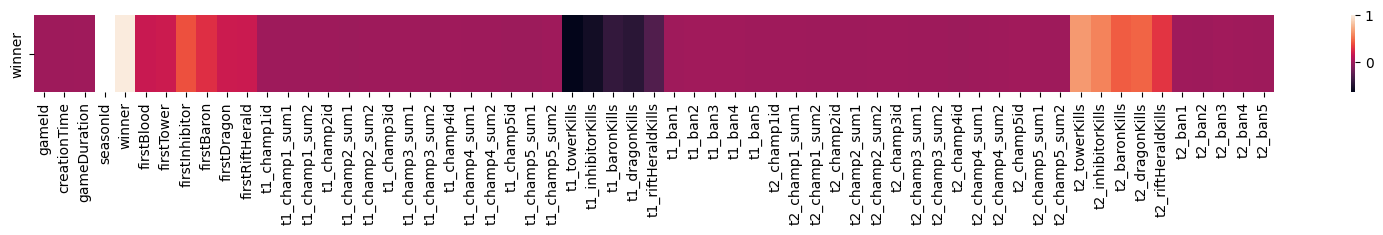

In [ ]:
winner_correlation = df.corr()['winner'].to_frame().T
plt.subplots(figsize=(20, 1))
sns.heatmap(winner_correlation)
# plt.savefig("winner_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
correlation_threshold = 0.3

# According to the correlation values, we filter the useful attributes.
attributes = list(filter(lambda x: abs(float(winner_correlation[x])) > correlation_threshold, df.columns))

print('Total of useful attributes:', len(attributes), '.')

Total of useful attributes: 11 .


In [ ]:
print(attributes)

['winner', 'firstInhibitor', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']


In [ ]:
# We filter the attributes that represent the objective kills of the winning/losing team.
objectives = list(filter(lambda x: 'Kills' in x, attributes))

# We modify the names of the attributes to make them more understandable.
objectives = list(set(map(lambda x: x.split('_')[-1], objectives)))

fig, ax = plt.subplots(1, len(objectives), figsize=(15, 5))

for i, objective in enumerate(objectives):

    # We filter the games in which the team 1 has won.
    t1_wins = df[df['winner'] == 1][['t1_' + objective, 't2_' + objective]]
    t1_wins.columns = ['winner', 'loser']

    # We filter the games in which the team 2 has won.
    t2_wins = df[df['winner'] == 2][['t2_' + objective, 't1_' + objective]]
    t2_wins.columns = ['winner', 'loser']

    # We compute the mean of the winning/losing objective kills.
    mean = pd.concat([t1_wins, t2_wins], axis=0).mean(axis=0)

    ax[i].set_title(objective.replace('Kills', ' number of kills').capitalize())

    sns.barplot(x=['Winning Team', 'Losing Team'],
                y=[mean['winner'], mean['loser']],
                palette='cool',
                ax=ax[i])
# plt.savefig("mean_distribution_kills.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# We keep only the useful attributes.
df_dt = df[attributes]

In [ ]:
X = df_dt.drop(labels=['winner'], axis=1)
y = df_dt['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
k = 10

# We define the parameters we want to try.
parameters = dict()
parameters['splitter'] = ['best', 'random']
parameters['max_depth'] = range(1, len(attributes))
parameters['criterion'] = ['gini', 'entropy']

dt = DecisionTreeClassifier()

# We search for the best combination of the parameters.
grid_dt = GridSearchCV(estimator=dt, cv=k, param_grid=parameters)
grid_dt.fit(X_train, y_train)

print("Best parameters: ", grid_dt.best_params_)

Best parameters:  {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}


In [ ]:
#We get the best combination of the parameters found.
best_params = grid_dt.best_params_
best_criterion = best_params['criterion']
best_max_depth = best_params['max_depth']
best_splitter = best_params['splitter']

# We fit the decision tree with these parameters.
dt = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth, splitter=best_splitter)
dt = dt.fit(X_train, y_train)

In [ ]:
tuned_dt = grid_dt.best_estimator_

In [ ]:
y_pred = dt.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred)*100, 2)

print('Accuracy:', accuracy, '%')

Accuracy: 95.91 %


In [ ]:
# We take the probabilities of the predictions.
y_pred = dt.predict_proba(X_test)

# We represent the y_test in the format we need to compute the ROC curve.
y_test = y_test.apply(lambda x: 0 if x == 1 else 1)

# We compute the ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

# We represent the ROC curve.
roc_curve = go.Scatter(x=fpr, y=tpr, name="ROC curve", marker_color='#1DA6FF')
reference = go.Scatter(x=fpr, y=fpr, name="Reference", marker_color='#4F555D')

data = [roc_curve, reference]

figure = go.Figure(data)
figure.update_layout(title="Roc curve",
                     xaxis=dict(title="False Positive Rate (FPR)"),
                     yaxis=dict(title="True Positive Rate (TPR)"),
                     width=800,
                     height=400)

iplot(figure)

In [ ]:
fn = list(X_train.columns)
cn = ['Team 1 wins', 'Team 2 wins']

fig, axes = plt.subplots(figsize=(25, 10))
tree.plot_tree(dt, feature_names=fn, class_names=cn)
plt.show()

In [ ]:
# maximum depth equal to 2.
simple_dt = DecisionTreeClassifier(criterion=best_criterion, max_depth=2, splitter=best_splitter)
simple_dt = simple_dt.fit(X_train, y_train)

fig, axes = plt.subplots(figsize=(50, 50))
tree.plot_tree(simple_dt, feature_names=fn, class_names=cn)
plt.savefig("DT_view_max_2.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Logistic Regression

In [ ]:
X = df.drop(labels=['winner'], axis=1)
y = df['winner']


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,sep="\n")

(50085, 60)
(12522, 60)
(50085,)
(12522,)


In [ ]:
# fit logistic regression model
from sklearn.linear_model import LogisticRegression

grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300]
}

lr = LogisticRegression()

grid_lr = GridSearchCV(lr, grid, cv=5, n_jobs=-1, verbose=2)

grid_lr.fit(X_train, y_train)

# get accuracy score
tuned_lr = grid_lr.best_estimator_
predict_lr = tuned_lr.predict(X_test)
accuracy_lr = accuracy_score(predict_lr, y_test)
print(accuracy_lr)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0.9499281264973647


In [ ]:
print("Best parameters found: ", grid_lr.best_params_)

Best parameters found:  {'C': 0.1, 'max_iter': 100, 'solver': 'newton-cg'}


In [ ]:
#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# search the best params
grid = {'n_estimators':[100,200,300,400,500], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10]}

rf = RandomForestClassifier(random_state=100)

grid_rf = GridSearchCV(rf, grid, cv=5)
grid_rf.fit(X_train, y_train)

print("Best parameters found: ", grid_rf.best_params_)

tuned_rf = grid_rf.best_estimator_

predict_rf = tuned_rf.predict(X_test)
# get the accuracy score
accuracy_rf = accuracy_score(predict_rf, y_test)
print(f"RF Model Accuracy with Best Parameters: {accuracy:.2%}")

Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}
RF Model Accuracy with Best Parameters: 9591.00%


In [ ]:
accuracy_rf = accuracy_score(predict_rf, y_test)
print("Best parameters found: ", grid_rf.best_params_)
print(f"RF Model Accuracy with Best Parameters: {accuracy_rf:.2%}")


Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}
RF Model Accuracy with Best Parameters: 96.47%


In [ ]:
#Gradient Boosting Machine

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gbm = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_gbm = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_gbm.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_gbm.best_params_)

# Evaluate the best model
tuned_gbm = grid_gbm.best_estimator_

y_pred = tuned_gbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"GBM Model Accuracy with Best Parameters: {accuracy:.2%}")



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
GBM Model Accuracy with Best Parameters: 96.65%


In [ ]:
game={
    "feature":["first_blood","first_tower","first_inhibitor","first_Baron","first_Dragon","first_RiftHerald",
"t1_tower","t1_inhibitor","t1_baron","t1_dragon","t2_tower","t2_inhibitor","t2_baron","t2_dragon"],
         "value":[1,1,2,1,1,1,12,3,2,5,9,3,2,2]}
game_frame=pd.DataFrame(game).T
game_frame
games_results = game_frame.loc['value'].values.reshape(1, -1)
games_results

array([[1, 1, 2, 1, 1, 1, 12, 3, 2, 5, 9, 3, 2, 2]], dtype=object)

In [ ]:
print(tuned_dt.n_features_in_)


10
